# Deep Q Networks

This notebook demonstrates how to solve OpenAI gym environments using DQN. It defaults to the LunarLander-v2 environment. Based on the environment, the network might need to be structured differently.

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from replay_buffer import ReplayBuffer
from torchsummary import summary
from typing import List

In [2]:
class DQN(nn.Module):
    def __init__(
        self,
        input_dims: int,
        num_actions: int,
    ) -> None:
        super().__init__()

        self.input_dims = input_dims
        self.num_actions = num_actions

        def block(in_features: int, out_features: int) -> nn.Sequential:
            return nn.Sequential(
                nn.Linear(in_features=in_features, out_features=out_features),
                nn.LeakyReLU(0.25),
            )

        self.network = nn.Sequential(
            block(input_dims, 128),
            block(128, 128),
        )
        self.Q = nn.Sequential(
            nn.Linear(in_features=128, out_features=num_actions), nn.LeakyReLU(0.25)
        )

    def forward(self, state: torch.FloatTensor) -> torch.FloatTensor:
        x = self.network(state)
        Q = self.Q(x)
        return Q


class DQNAgent:
    def __init__(
        self,
        input_dims: int,
        num_actions: int,
        *,
        environment: str = "",
        learning_rate: float = 0.001,
        gamma: float = 0.99,
        batch_size: int = 64,
        epsilon: float = 1,
        epsilon_decrement: float = 0.001,
        min_epsilon: float = 0.01,
        memory_size: int = 100000,
        filename: str = "agent",
        device: str = "cpu",
        warmup_steps: int = 100,
    ) -> None:
        self.input_dims = input_dims
        self.num_actions = num_actions
        self.environment = environment
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epsilon_decrement = epsilon_decrement
        self.min_epsilon = min_epsilon
        self.memory_size = memory_size
        self.filename = f"{environment}_{filename}"
        self.device = device
        self.warmup_steps = warmup_steps

        self.action_space = list(range(num_actions))
        self.memory = ReplayBuffer(memory_size, input_dims)
        self.network = DQN(input_dims=input_dims[0], num_actions=num_actions).to(
            self.device
        )

        self.loss_fn = nn.HuberLoss()
        self.optimizer = optim.AdamW(self.network.parameters(), lr=learning_rate)

    def get_training_action(self, observation: np.ndarray) -> int:
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            state = torch.tensor(np.array([observation])).to(self.device)
            actions = self.network(state)
            action = torch.argmax(actions).item()
        return int(action)

    def get_testing_action(self, observation: np.ndarray) -> int:
        state = torch.tensor(np.array([observation])).to(self.device)
        actions = self.network(state)
        action = torch.argmax(actions).item()
        return int(action)

    def learn(self) -> None:
        self.network.train()

        # Do not learn if there are not enough experiences in the replay buffer
        if self.memory.memory_counter < self.warmup_steps:
            return

        # Sample a batch of experiences from the replay buffer
        states, actions, rewards, next_states, terminals = map(
            lambda x: torch.tensor(x).to(self.device),
            self.memory.sample_buffer(self.batch_size),
        )
        batch_indices = np.arange(self.batch_size)

        # Compute Q-values for current states
        q_eval = self.network(states)[batch_indices, actions]

        # Compute Q-values for next states
        q_next = self.network.forward(next_states)
        q_next[terminals] = 0

        q_target = rewards + self.gamma * torch.max(q_next, dim=1)[0]

        # Compute the loss
        loss = self.loss_fn(q_target, q_eval)

        # Backpropagate the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Epsilon-greedy policy
        self.epsilon = (
            self.epsilon - self.epsilon_decrement
            if self.epsilon > self.min_epsilon
            else self.min_epsilon
        )

    def save_model(self) -> None:
        torch.save(self.network, f"{self.filename}.pt")

    def load_model(self) -> None:
        self.network = torch.load(f"{self.filename}.pt")

In [3]:
environment = "LunarLander-v2"
env = gym.make(environment)

In [4]:
input_dims = env.observation_space.shape
num_actions = env.action_space.n
learning_rate = 5e-3
gamma = 0.99
batch_size = 512
epsilon = 1
epsilon_decrement = 0.0001
min_epsilon = 0.01
memory_size = 100000
filename = "dqn_agent"
warmup_steps = 1000
device = "cuda" if torch.cuda.is_available() else "cpu"

num_episodes = 300
max_episode_steps = 400
num_learning_steps = 0

In [5]:
agent = DQNAgent(
    input_dims=input_dims,
    num_actions=num_actions,
    learning_rate=learning_rate,
    gamma=gamma,
    batch_size=batch_size,
    epsilon=epsilon,
    epsilon_decrement=epsilon_decrement,
    min_epsilon=min_epsilon,
    memory_size=memory_size,
    filename=filename,
    warmup_steps=warmup_steps,
    device=device,
)

In [6]:
_ = summary(agent.network)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Sequential: 2-1                   --
|    |    └─Linear: 3-1                  1,152
|    |    └─LeakyReLU: 3-2               --
|    └─Sequential: 2-2                   --
|    |    └─Linear: 3-3                  16,512
|    |    └─LeakyReLU: 3-4               --
├─Sequential: 1-2                        --
|    └─Linear: 2-3                       516
|    └─LeakyReLU: 2-4                    --
Total params: 18,180
Trainable params: 18,180
Non-trainable params: 0


In [7]:
seed = 1337
torch.manual_seed(seed)
np.random.seed(seed)

In [8]:
scores = []

for i in range(num_episodes):
    steps = 0
    observation = env.reset()[0]
    score = 0
    done = False

    while steps < max_episode_steps and not done:
        action = agent.get_training_action(observation)

        next_observation, reward, terminated, truncated, info = env.step(action)
        score += reward
        done = terminated | truncated
        agent.memory.store_transition(
            observation, action, reward, next_observation, done
        )
        agent.learn()
        observation = next_observation
        steps += 1

    if agent.epsilon <= agent.min_epsilon:
        for _ in range(num_learning_steps):
            agent.learn()

    scores.append(score)
    print(i, steps, score)

0 99 -144.05180560069488
1 65 -62.03985699528567
2 145 -157.4523510275875
3 101 -227.64808967475545
4 66 -144.7743992533503
5 96 -1.0541673954003272
6 102 -132.96309449710975
7 155 -441.33105773692307
8 85 -89.16519219800739
9 127 -265.70011519431296
10 106 -128.36361055389983
11 96 -245.82097760533998
12 85 -84.74084886128426
13 85 -319.36376511216895
14 129 -120.72603916686788
15 82 -96.87592341453463
16 76 -114.0676597175219
17 112 -156.07642115653883
18 67 -93.33235746847733
19 101 -294.3573766011558
20 105 -168.08409981443052
21 77 -91.18794554266032
22 76 -149.12750392423527
23 73 -177.09058549406876
24 82 -97.74135674156943
25 137 -141.42918464745867
26 88 -94.95053613997305
27 111 -83.02513807879465
28 88 -113.24747898097328
29 114 -43.603352459929084
30 69 -150.21094327667342
31 69 -99.16271203476666
32 117 -147.10085846829452
33 124 -66.79557110455156
34 76 -50.143920345854426
35 133 -43.9099308419151
36 107 -69.04726953915215
37 127 -298.68171283122
38 168 -87.40276866899725

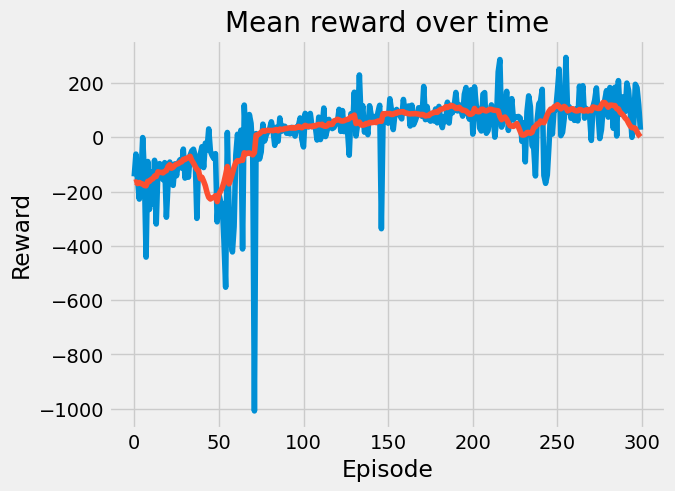

In [9]:
window_size = 16
mean_scores = [
    sum(scores[i : i + window_size]) / len(scores[i : i + window_size])
    for i in range(len(scores))
]
plt.style.use("fivethirtyeight")
plt.plot(scores)
plt.plot(mean_scores)
plt.title("Mean reward over time")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

In [10]:
environment = "LunarLander-v2"
env = gym.make(environment, render_mode="human")

In [17]:
steps = 0
observation = env.reset()[0]
score = 0
done = False

while steps < max_episode_steps and not done:
    action = agent.get_testing_action(observation)

    next_observation, reward, terminated, truncated, info = env.step(action)
    score += reward
    done = terminated | truncated
    observation = next_observation
    steps += 1

print(score)

220.6083536693531
